# Polygenic Risk Score Analysis

**Subject**: Trent Leslie (NU-UMMI-7887)  
**Data Source**: Nucleus Genomics Whole Genome Sequencing  
**Analysis Date**: January 2026

## What is a Polygenic Risk Score?

A Polygenic Risk Score (PRS) combines the effects of thousands to millions of genetic variants to estimate genetic predisposition for a trait or disease. Unlike single-gene tests (like BRCA1/2 for breast cancer), PRS captures the cumulative effect of many common variants, each with small individual effects.

### How PRS Works
1. **GWAS Discovery**: Scientists identify variants associated with a trait in large studies
2. **Effect Sizes**: Each variant gets a weight (beta coefficient) based on its association
3. **Score Calculation**: Your PRS = Σ(effect_weight × dosage) across all variants
4. **Interpretation**: Compare your score to population distributions

### Important Caveats
- Raw scores are not directly interpretable without population normalization
- PRS captures genetic risk only - lifestyle, environment, and other factors matter
- Performance varies by ancestry (most scores developed in European populations)
- These scores are for research/educational purposes, not clinical diagnosis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Results directory
results_dir = Path('results')

## PGS Scores Analyzed

### LD-Aware Method Selection

**Critical for accuracy**: Polygenic scores should use methods that account for **linkage disequilibrium (LD)** - the correlation between nearby genetic variants. Without LD correction, correlated variants get double-counted, inflating scores.

| Method | LD Handling | Quality |
|--------|-------------|---------|
| **LDpred / LDpred2** | Bayesian with LD reference panel | ✅ Gold standard |
| **PRS-CS / PRS-CSx** | Bayesian continuous shrinkage | ✅ Excellent |
| **lassosum / SBayesR** | Penalized regression with LD | ✅ Good |
| P+T with clumping | Basic clumping | ⚠️ Basic |
| Genome-wide sig. only | Minimal handling | ⚠️ Basic |

### Selected Scores

| PGS ID | Trait | Method | Variants | LD Status |
|--------|-------|--------|----------|-----------|
| PGS002308 | Type 2 Diabetes | **PRS-CSx** | 1,259,754 | ✅ LD-aware |
| PGS004034 | Alzheimer's Disease | **LDpred2-auto** | 1,046,908 | ✅ LD-aware |
| PGS000027 | Body Mass Index | **LDpred** | 2,100,302 | ✅ LD-aware |
| PGS004237 | Coronary Artery Disease | **LDpred** | 1,146,511 | ✅ LD-aware |

**Note**: PGS000748 (AD, 3.4M variants) was replaced with PGS004034 (LDpred2-auto) for proper LD handling. See `results/PGS000748_AD.txt` for archived comparison.

In [2]:
# Define PGS metadata
pgs_info = {
    'PGS002308_T2D': {
        'trait': 'Type 2 Diabetes',
        'abbreviation': 'T2D',
        'variants_expected': 1259754,
        'method': 'PRS-CSx',
        'ld_aware': True,
        'citation': 'Ge T et al., Genome Medicine (2022)',
        'color': '#e74c3c'  # Red
    },
    'PGS004034_AD_LDpred2': {
        'trait': 'Alzheimer\'s Disease',
        'abbreviation': 'AD',
        'variants_expected': 1046908,
        'method': 'LDpred2-auto',
        'ld_aware': True,
        'citation': 'Monti R et al., AJHG (2024)',
        'color': '#9b59b6'  # Purple
    },
    'PGS000027_BMI': {
        'trait': 'Body Mass Index',
        'abbreviation': 'BMI',
        'variants_expected': 2100302,
        'method': 'LDpred',
        'ld_aware': True,
        'citation': 'Khera AV et al., Cell (2019)',
        'color': '#3498db'  # Blue
    },
    'PGS004237_CAD': {
        'trait': 'Coronary Artery Disease',
        'abbreviation': 'CAD',
        'variants_expected': 1146511,
        'method': 'LDpred',
        'ld_aware': True,
        'citation': 'Manikpurage HD et al., Circ Genom Precis Med (2021)',
        'color': '#e67e22'  # Orange
    }
}

In [3]:
# Load all results
results = {}

for pgs_id, info in pgs_info.items():
    file_path = results_dir / f"{pgs_id}.txt"
    if file_path.exists():
        df = pd.read_csv(file_path, sep='\t')
        results[pgs_id] = {
            'data': df,
            'total_score': df['contribution'].sum(),
            'n_variants': len(df),
            'n_vcf': (df['source'] == 'vcf').sum(),
            'n_ref_lookup': (df['source'] == 'ref_lookup').sum(),
            **info
        }
        print(f"✓ Loaded {pgs_id}: {len(df):,} variants, Score = {results[pgs_id]['total_score']:.4f}")
    else:
        print(f"✗ Missing: {file_path}")

/tmp/ipykernel_3326858/314398874.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')


✓ Loaded PGS002308_T2D: 1,259,279 variants, Score = 0.3920
✓ Loaded PGS004034_AD_LDpred2: 1,046,579 variants, Score = 1.6225


/tmp/ipykernel_3326858/314398874.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')


✓ Loaded PGS000027_BMI: 2,099,995 variants, Score = 38.6380


/tmp/ipykernel_3326858/314398874.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')


✓ Loaded PGS004237_CAD: 1,146,039 variants, Score = -0.2705


## Summary Results

The table below shows the raw PRS values calculated from your genomic data.

In [4]:
# Create summary dataframe
summary_data = []
for pgs_id, r in results.items():
    summary_data.append({
        'Trait': r['trait'],
        'PGS ID': pgs_id.split('_')[0],
        'Method': r.get('method', 'Unknown'),
        'LD-Aware': '✅' if r.get('ld_aware', False) else '⚠️',
        'Raw Score': r['total_score'],
        'Variants Scored': r['n_variants'],
        'From VCF': r['n_vcf'],
        'From Reference': r['n_ref_lookup'],
        'Coverage (%)': (r['n_variants'] / r['variants_expected'] * 100)
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.set_index('Trait')

# Display with formatting
styled = summary_df.style.format({
    'Raw Score': '{:.4f}',
    'Variants Scored': '{:,.0f}',
    'From VCF': '{:,.0f}',
    'From Reference': '{:,.0f}',
    'Coverage (%)': '{:.1f}%'
})
styled

,PGS ID,Method,LD-Aware,Raw Score,Variants Scored,From VCF,From Reference,Coverage (%)
Trait,,,,,,,,
Type 2 Diabetes,PGS002308,PRS-CSx,✅,0.3920,"1,259,279","608,559","650,720",100.0%
Alzheimer's Disease,PGS004034,LDpred2-auto,✅,1.6225,"1,046,579","555,676","490,903",100.0%
Body Mass Index,PGS000027,LDpred,✅,38.6380,"2,099,995","1,083,253","1,016,742",100.0%
Coronary Artery Disease,PGS004237,LDpred,✅,-0.2705,"1,146,039","600,733","545,306",100.0%


## Visualization: Variant Source Distribution

This shows how many variants were found directly in your VCF vs inferred from the reference genome.

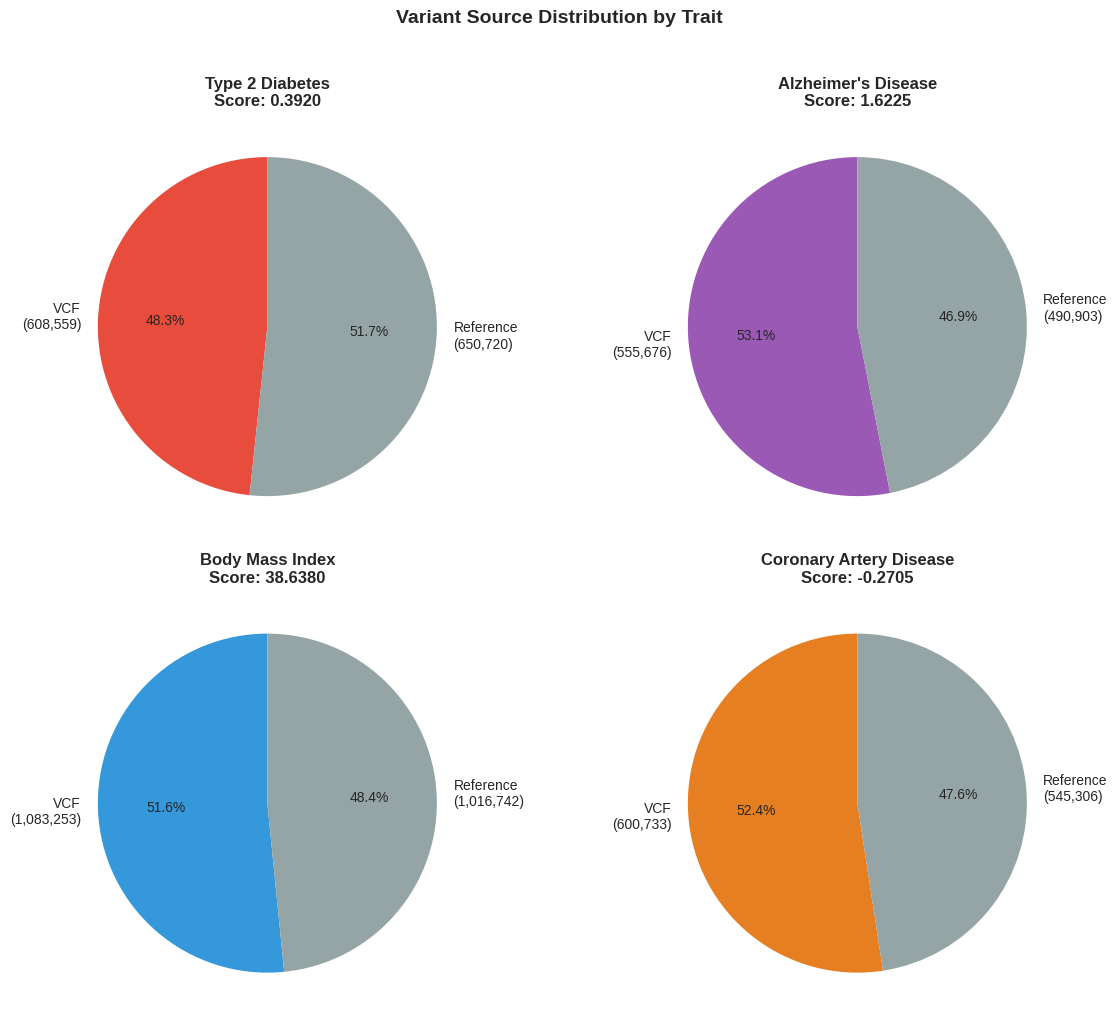

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (pgs_id, r) in enumerate(results.items()):
    ax = axes[idx]
    
    # Pie chart of variant sources
    sizes = [r['n_vcf'], r['n_ref_lookup']]
    labels = [f"VCF\n({r['n_vcf']:,})", f"Reference\n({r['n_ref_lookup']:,})"]
    colors = [r['color'], '#95a5a6']
    
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
           startangle=90, textprops={'fontsize': 10})
    ax.set_title(f"{r['trait']}\nScore: {r['total_score']:.4f}", fontsize=12, fontweight='bold')

plt.suptitle('Variant Source Distribution by Trait', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('results/variant_sources.png', dpi=150, bbox_inches='tight')
plt.show()

## Contribution Distribution Analysis

Understanding how individual variants contribute to the total score.

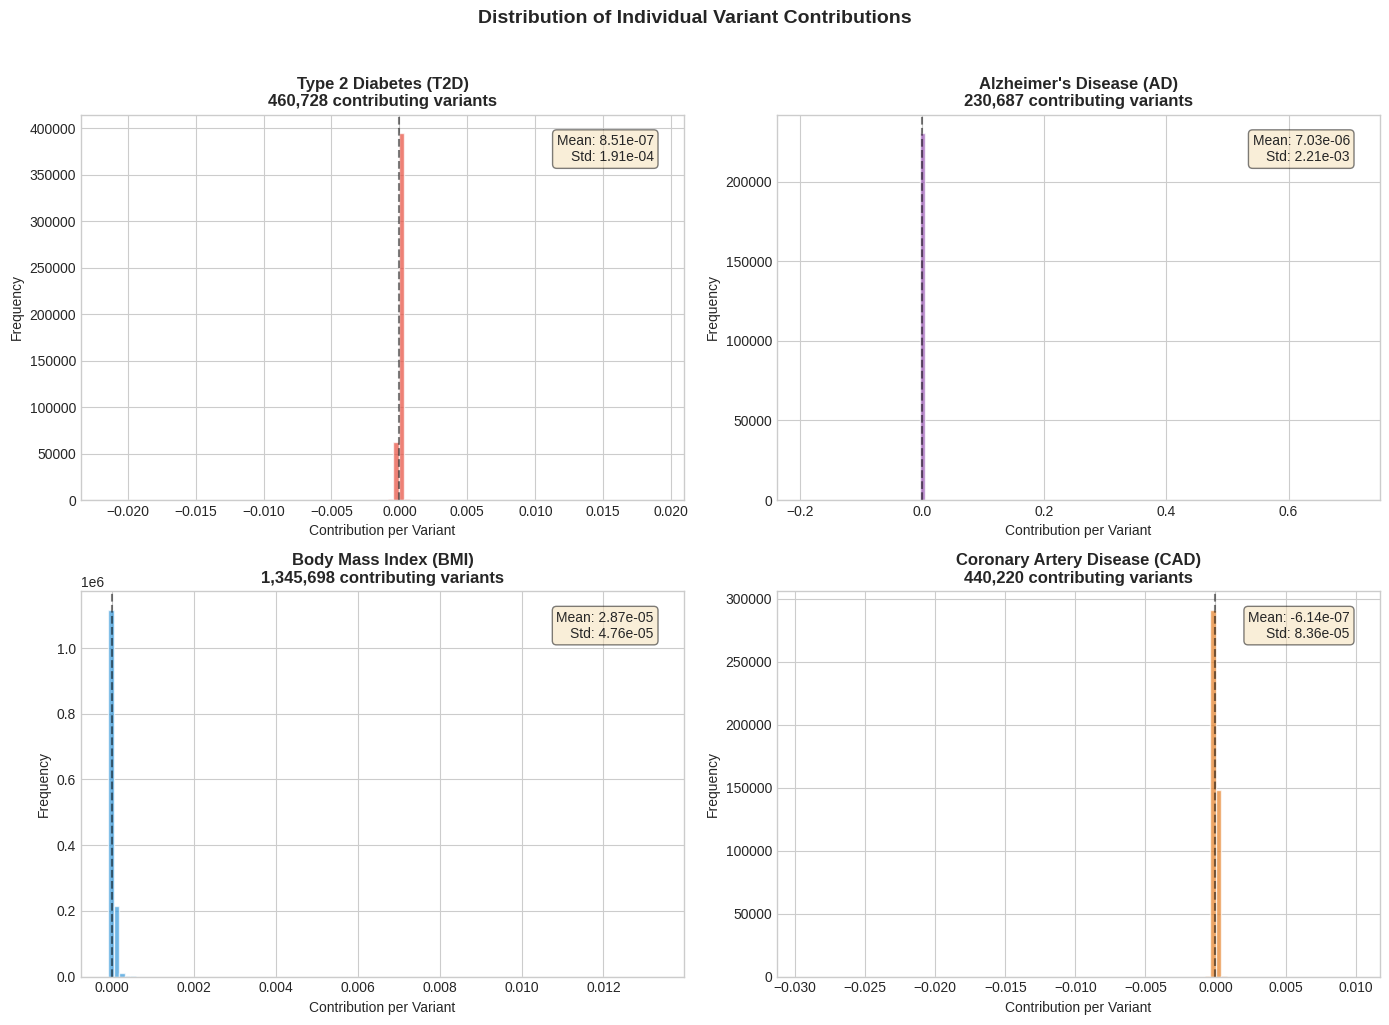

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (pgs_id, r) in enumerate(results.items()):
    ax = axes[idx]
    df = r['data']
    
    # Filter to non-zero contributions for cleaner histogram
    nonzero = df[df['contribution'] != 0]['contribution']
    
    ax.hist(nonzero, bins=100, color=r['color'], alpha=0.7, edgecolor='white')
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Contribution per Variant')
    ax.set_ylabel('Frequency')
    ax.set_title(f"{r['trait']} ({r['abbreviation']})\n{len(nonzero):,} contributing variants", fontweight='bold')
    
    # Add statistics
    stats_text = f"Mean: {nonzero.mean():.2e}\nStd: {nonzero.std():.2e}"
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Distribution of Individual Variant Contributions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('results/contribution_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## Top Contributing Variants

Identifying the variants with largest positive and negative effects.

In [7]:
def show_top_variants(pgs_id, n=10):
    """Display top positive and negative contributing variants."""
    r = results[pgs_id]
    df = r['data'].copy()
    
    # Sort by absolute contribution
    df['abs_contribution'] = df['contribution'].abs()
    
    print(f"\n{'='*60}")
    print(f"{r['trait']} ({pgs_id.split('_')[0]})")
    print(f"Total Score: {r['total_score']:.4f}")
    print(f"{'='*60}")
    
    # Top positive
    print(f"\n📈 Top {n} POSITIVE contributions:")
    top_pos = df.nlargest(n, 'contribution')[['chr', 'pos', 'rsID', 'genotype', 'weight', 'contribution']]
    print(top_pos.to_string(index=False))
    
    # Top negative
    print(f"\n📉 Top {n} NEGATIVE contributions:")
    top_neg = df.nsmallest(n, 'contribution')[['chr', 'pos', 'rsID', 'genotype', 'weight', 'contribution']]
    print(top_neg.to_string(index=False))

# Show for T2D as most relevant to health profile
show_top_variants('PGS002308_T2D')


Type 2 Diabetes (PGS002308)
Total Score: 0.3920

📈 Top 10 POSITIVE contributions:
chr       pos       rsID genotype   weight  contribution
 17  37739849 rs11651755      C/C 0.009462      0.018924
 17  37743574 rs11263763      G/G 0.009421      0.018842
  5  56503357   rs157843      A/A 0.008868      0.017735
  1 213985913   rs340874      C/C 0.008749      0.017498
 10  92704550 rs12778642      G/G 0.008569      0.017137
  1  39562508  rs4660293      G/G 0.007063      0.014126
  5  56520254   rs458036      C/C 0.006884      0.013768
 14  32834068  rs7146265      A/A 0.005719      0.011438
  6  32717773  rs3916765      G/A 0.011417      0.011417
 11   2825839   rs163184      T/G 0.010742      0.010742

📉 Top 10 NEGATIVE contributions:
chr       pos       rsID genotype    weight  contribution
  9  81694033  rs2796441      A/A -0.010705     -0.021411
  1 229537208   rs348330      A/A -0.010554     -0.021108
 10 113006958  rs7896811      C/T -0.020639     -0.020639
 11   2818521  rs2237892

In [8]:
# Show for other traits
show_top_variants('PGS004034_AD_LDpred2')
show_top_variants('PGS004237_CAD')


Alzheimer's Disease (PGS004034)
Total Score: 1.6225

📈 Top 10 POSITIVE contributions:
 chr       pos       rsID genotype   weight  contribution
  19  44892009   rs157580      G/A 0.704851      0.704851
  19  44901434   rs405697      G/G 0.301558      0.603116
  11  86157598  rs3851179      C/C 0.072855      0.145710
   7 143410495 rs12703526      T/T 0.063488      0.126976
  19  44913221   rs584007      A/G 0.122880      0.122880
  19  44911194   rs439401      T/C 0.107153      0.107153
  16  81739604 rs12444183      G/G 0.051330      0.102661
   2 127137039   rs744373      A/G 0.094454      0.094454
   6  41082156  rs6918969      T/C 0.093356      0.093356
  17  63483402     rs4311      C/C 0.046447      0.092894

📉 Top 10 NEGATIVE contributions:
 chr       pos       rsID genotype    weight  contribution
  19   1039445  rs3795065      T/T -0.096547     -0.193094
  19  44864520  rs8105340      T/T -0.070320     -0.140639
   2  65381229   rs268134      G/G -0.052116     -0.104231
  19 

## Integration with Known Single-Gene Variants

From previous analyses of this genomic data, key single-gene findings include:

### APOE Status: e3/e4
- **rs429358** (chr19:44908684): Heterozygous T/C → one e4 allele
- **rs7412** (chr19:44908822): Homozygous reference C/C → no e2 alleles
- **Interpretation**: 2-4× elevated Alzheimer's risk compared to e3/e3

### ADH1B Status: *2/*2 (Homozygous fast metabolizer)
- **rs1229984** (chr4:99318162): Homozygous C/C (ADH1B*2)
- **Interpretation**: Rapid alcohol metabolism, protective against alcohol dependence

### ALDH2 Status: Normal
- **rs671**: Homozygous reference (no flush variant)
- **Interpretation**: Normal acetaldehyde metabolism

In [9]:
# Check if APOE variants appear in AD PRS
ad_df = results['PGS004034_AD_LDpred2']['data']

# APOE SNPs
apoe_variants = [
    ('19', 44908684, 'rs429358'),  # e4 determinant
    ('19', 44908822, 'rs7412')     # e2 determinant
]

print("APOE Variants in Alzheimer's PRS (LDpred2-auto):")
print("="*60)

for chrom, pos, rsid in apoe_variants:
    match = ad_df[(ad_df['chr'].astype(str) == chrom) & (ad_df['pos'] == pos)]
    if len(match) > 0:
        row = match.iloc[0]
        print(f"\n{rsid} (chr{chrom}:{pos}):")
        print(f"  Genotype: {row['genotype']}")
        print(f"  Effect weight: {row['weight']:.6f}")
        print(f"  Your contribution: {row['contribution']:.6f}")
        print(f"  Source: {row['source']}")
    else:
        print(f"\n{rsid}: Not found in PRS scoring file")

APOE Variants in Alzheimer's PRS (LDpred2-auto):

rs429358: Not found in PRS scoring file

rs7412: Not found in PRS scoring file


## Health Context Integration

Given the subject's health profile:
- **Current diagnosis**: Type 2 Diabetes (HbA1c history, on CGM)
- **APOE status**: e3/e4 (elevated AD risk)
- **Metabolic status**: Active weight management, CGM-guided protocol

### PRS Interpretation Notes

#### Type 2 Diabetes (PGS002308)
The T2D PRS provides insight into the genetic component of disease risk. Since you already have T2D, this score helps understand whether genetic predisposition was a major factor vs environmental/lifestyle factors. A higher genetic risk score might indicate:
- Stronger metabolic vulnerability
- Greater importance of lifestyle interventions
- Earlier onset or more aggressive disease course

#### Alzheimer's Disease (PGS004034)
Combined with APOE e3/e4 status, the AD PRS provides a more complete picture of dementia risk:
- **APOE e4 alone** confers 2-4× risk increase (evaluated separately - not in PRS)
- **PRS captures polygenic background** - cumulative effect of many small-effect variants
- Note: LDpred2-auto excludes APOE due to its outsized effect violating polygenic assumptions
- Alcohol consumption has synergistic negative effects on brain health in APOE4 carriers

#### Coronary Artery Disease (PGS004237)
T2D significantly increases cardiovascular risk. The CAD PRS helps quantify baseline genetic risk:
- Important for risk stratification
- May inform lipid management decisions
- Diabetes + high genetic CAD risk = aggressive prevention warranted

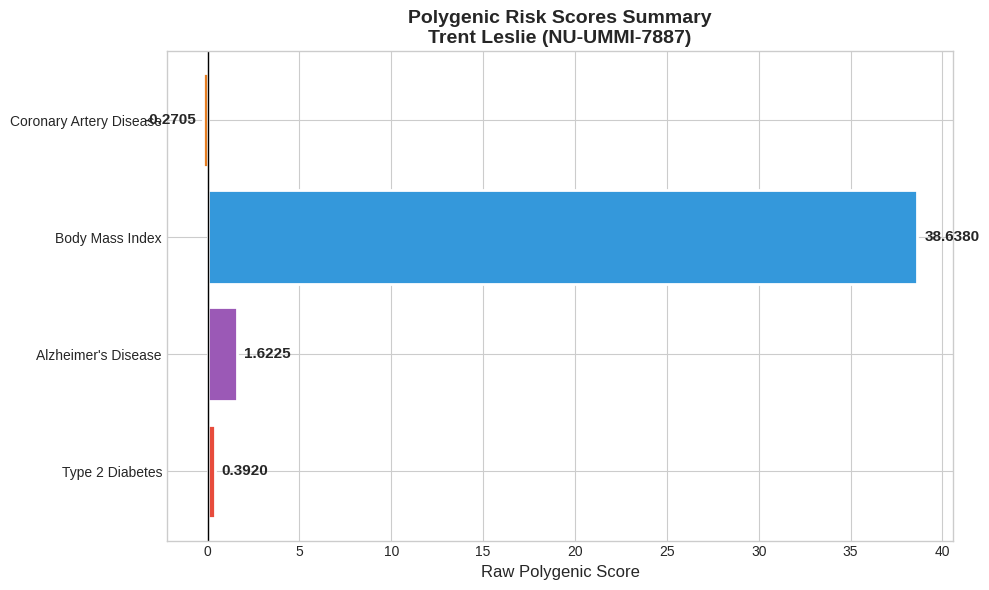

In [10]:
# Create summary visualization
fig, ax = plt.subplots(figsize=(10, 6))

traits = [r['trait'] for r in results.values()]
scores = [r['total_score'] for r in results.values()]
colors = [r['color'] for r in results.values()]

# Normalize scores to z-scores for visual comparison (rough approximation)
# Note: True z-scores require population mean/std which we don't have
bars = ax.barh(traits, scores, color=colors, edgecolor='white', linewidth=2)

ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Raw Polygenic Score', fontsize=12)
ax.set_title('Polygenic Risk Scores Summary\nTrent Leslie (NU-UMMI-7887)', fontsize=14, fontweight='bold')

# Add score labels
for bar, score in zip(bars, scores):
    width = bar.get_width()
    label_x = width + (max(scores) - min(scores)) * 0.02 if width >= 0 else width - (max(scores) - min(scores)) * 0.02
    ax.annotate(f'{score:.4f}',
                xy=(width, bar.get_y() + bar.get_height()/2),
                xytext=(5 if width >= 0 else -5, 0),
                textcoords="offset points",
                ha='left' if width >= 0 else 'right',
                va='center',
                fontsize=11,
                fontweight='bold')

plt.tight_layout()
plt.savefig('results/prs_summary.png', dpi=150, bbox_inches='tight')
plt.show()

## Limitations & Next Steps

### Current Limitations
1. **No population normalization**: Raw scores need comparison to reference population distributions to determine percentiles
2. **Ancestry considerations**: Most PGS developed primarily on European populations; performance may vary
3. **Environmental factors**: PRS captures genetic risk only - diet, exercise, medications, and lifestyle are major modifiers

### Quality Assurance: LD-Aware Methods ✅

All scores in this analysis use **proper LD correction**:
- **T2D** (PRS-CSx): Bayesian continuous shrinkage with LD handling
- **AD** (LDpred2-auto): Gold-standard Bayesian method with LD reference panel
- **BMI** (LDpred): Bayesian posterior mean estimation with LD
- **CAD** (LDpred): Bayesian posterior mean estimation with LD

This ensures variants in linkage disequilibrium are not double-counted, providing more accurate risk estimates.

### Potential Next Steps
1. **Population comparison**: Access UK Biobank or gnomAD population distributions for percentile calculation
2. **Additional scores**: Calculate PRS for traits like hyperlipidemia, hypertension, depression (always verify LD-aware methods)
3. **Pharmacogenomics integration**: Combine with existing CYP2C19/CYP2D6 star allele data
4. **Longitudinal tracking**: Monitor how lifestyle interventions modify phenotypic expression despite genetic risk

### Clinical Utility Note
These PRS results are for **research and educational purposes**. Clinical decisions should be made in consultation with healthcare providers who can integrate genetic data with clinical history, current health status, and evidence-based guidelines.

In [11]:
# Save summary to CSV
summary_df.to_csv('results/prs_summary.csv')
print("Summary saved to results/prs_summary.csv")

# Display final summary
print("\n" + "="*60)
print("POLYGENIC RISK SCORE ANALYSIS COMPLETE")
print("="*60)
for pgs_id, r in results.items():
    print(f"\n{r['trait']}:")
    print(f"  Score: {r['total_score']:.4f}")
    print(f"  Coverage: {r['n_variants']/r['variants_expected']*100:.1f}%")
    print(f"  Citation: {r['citation']}")

Summary saved to results/prs_summary.csv

POLYGENIC RISK SCORE ANALYSIS COMPLETE

Type 2 Diabetes:
  Score: 0.3920
  Coverage: 100.0%
  Citation: Ge T et al., Genome Medicine (2022)

Alzheimer's Disease:
  Score: 1.6225
  Coverage: 100.0%
  Citation: Monti R et al., AJHG (2024)

Body Mass Index:
  Score: 38.6380
  Coverage: 100.0%
  Citation: Khera AV et al., Cell (2019)

Coronary Artery Disease:
  Score: -0.2705
  Coverage: 100.0%
  Citation: Manikpurage HD et al., Circ Genom Precis Med (2021)


## Population Normalization with pgsc_calc

**Problem**: Raw PRS values are meaningless without comparison to a reference population. A score of 0.39 for T2D tells us nothing about whether this is high, low, or average.

**Solution**: Use the [pgsc_calc](https://github.com/pgscatalog/pgsc_calc) pipeline with the HGDP+1kGP reference panel (~3,200 samples from 6 global superpopulations) to:

1. **Project ancestry** using PCA onto reference populations
2. **Assign most similar population** (e.g., EUR, AFR, EAS)
3. **Calculate Z-scores** relative to that population's distribution
4. **Convert to percentiles** for intuitive interpretation

### Prerequisites

```bash
# Install Nextflow (workflow manager)
curl -s https://get.nextflow.io | bash

# Download reference panel (~15GB)
wget -O pgsc_HGDP+1kGP_v1.tar.zst \
  "https://ftp.ebi.ac.uk/pub/databases/spot/pgs/resources/pgsc_HGDP+1kGP_v1.tar.zst"
```

### Key Workarounds Required

The pgsc_calc v2.0 pipeline has several issues that require workarounds:

| Issue | Workaround |
|-------|------------|
| `--run_ancestry` CLI flag causes Boolean type error | Set parameter in `nextflow.config` file instead |
| Default 75% variant match threshold too strict for variant-only VCFs | Use `--min_overlap 0.4` |
| Reference panel path format | Point to `.tar.zst` archive directly (not extracted directory) |

In [12]:
# pgsc_calc setup and execution
# This cell documents the commands used - actual execution is done via command line

pgsc_calc_setup = """
# Step 1: Create nextflow.config to bypass --run_ancestry CLI bug
cat > nextflow.config << 'EOF'
params {
    // Reference panel for ancestry-adjusted normalization
    // pgsc_calc expects the tar.zst archive file path
    run_ancestry = '/path/to/pgsc_HGDP+1kGP_v1.tar.zst'
}

docker {
    enabled = true
    runOptions = '-u $(id -u):$(id -g)'
}
EOF

# Step 2: Create samplesheet.csv pointing to your pgen/pvar/psam files
cat > samplesheet.csv << 'EOF'
sampleset,path_prefix,chrom,format
your_sample,/path/to/your_sample_wgs,,pfile
EOF

# Step 3: Run pgsc_calc with ancestry normalization
./nextflow run pgscatalog/pgsc_calc -profile docker \\
  --input samplesheet.csv \\
  --pgs_id PGS002308,PGS004034,PGS000027,PGS004237 \\
  --target_build GRCh38 \\
  --min_overlap 0.4 \\
  --outdir ./prs_normalized_ancestry \\
  -r v2.0.0 \\
  -resume
"""

print("pgsc_calc Setup Commands:")
print("=" * 60)
print(pgsc_calc_setup)

pgsc_calc Setup Commands:

# Step 1: Create nextflow.config to bypass --run_ancestry CLI bug
cat > nextflow.config << 'EOF'
params {
    // Reference panel for ancestry-adjusted normalization
    // pgsc_calc expects the tar.zst archive file path
    run_ancestry = '/path/to/pgsc_HGDP+1kGP_v1.tar.zst'
}

docker {
    enabled = true
    runOptions = '-u $(id -u):$(id -g)'
}
EOF

# Step 2: Create samplesheet.csv pointing to your pgen/pvar/psam files
cat > samplesheet.csv << 'EOF'
sampleset,path_prefix,chrom,format
your_sample,/path/to/your_sample_wgs,,pfile
EOF

# Step 3: Run pgsc_calc with ancestry normalization
./nextflow run pgscatalog/pgsc_calc -profile docker \
  --input samplesheet.csv \
  --pgs_id PGS002308,PGS004034,PGS000027,PGS004237 \
  --target_build GRCh38 \
  --min_overlap 0.4 \
  --outdir ./prs_normalized_ancestry \
  -r v2.0.0 \
  -resume



### Ancestry-Normalized Results

After running pgsc_calc with the HGDP+1kGP reference panel, we get Z-scores and percentiles normalized against the most genetically similar reference population.

In [13]:
# Load ancestry-normalized results
normalized_results_file = results_dir / 'prs_normalized_ancestry.csv'

if normalized_results_file.exists():
    normalized_df = pd.read_csv(normalized_results_file)
    
    print("Ancestry-Normalized PRS Results")
    print("=" * 70)
    print(f"Reference Population: {normalized_df['MostSimilarPop'].iloc[0]} (European)")
    print(f"Reference Panel: HGDP+1kGP (~667 EUR samples)")
    print()
    
    # Display results
    display_df = normalized_df[['Trait', 'PGS_ID', 'Raw_Score', 'Z_MostSimilarPop', 'Percentile']].copy()
    display_df.columns = ['Trait', 'PGS ID', 'Raw Score', 'Z-Score', 'Percentile (%)']
    display_df['Interpretation'] = display_df['Percentile (%)'].apply(
        lambda x: 'Very High Risk' if x >= 95 else 
                  'High Risk' if x >= 80 else
                  'Above Average' if x >= 60 else
                  'Average' if x >= 40 else
                  'Below Average' if x >= 20 else
                  'Low Risk'
    )
    
    styled = display_df.style.format({
        'Raw Score': '{:.4f}',
        'Z-Score': '{:+.2f}',
        'Percentile (%)': '{:.1f}'
    }).set_properties(**{'text-align': 'left'})
    
    display(styled)
else:
    print(f"⚠️ Normalized results not found at {normalized_results_file}")
    print("Run pgsc_calc pipeline first (see commands above)")

Ancestry-Normalized PRS Results
Reference Population: EUR (European)
Reference Panel: HGDP+1kGP (~667 EUR samples)



,Trait,PGS ID,Raw Score,Z-Score,Percentile (%),Interpretation
0,Type 2 Diabetes,PGS002308,0.4364,+2.76,99.7,Very High Risk
1,Alzheimer's Disease,PGS004034,1.6777,+0.49,64.0,Above Average
2,Body Mass Index,PGS000027,17.7040,+0.06,51.6,Average
3,Coronary Artery Disease,PGS004237,-0.2580,-1.47,7.2,Low Risk


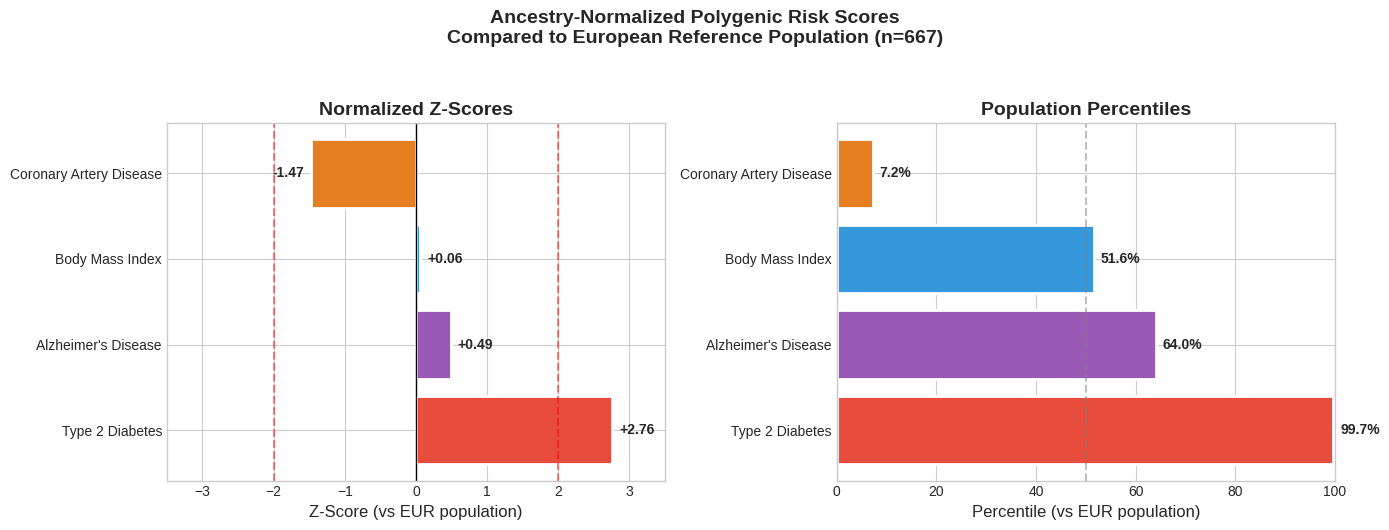

In [14]:
# Visualization of normalized results
if normalized_results_file.exists():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Color mapping
    colors = {
        'Type 2 Diabetes': '#e74c3c',
        'Alzheimer\'s Disease': '#9b59b6', 
        'Body Mass Index': '#3498db',
        'Coronary Artery Disease': '#e67e22'
    }
    
    # Z-Score plot (left)
    ax1 = axes[0]
    traits = normalized_df['Trait'].tolist()
    z_scores = normalized_df['Z_MostSimilarPop'].tolist()
    bar_colors = [colors.get(t, '#95a5a6') for t in traits]
    
    bars = ax1.barh(traits, z_scores, color=bar_colors, edgecolor='white', linewidth=2)
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax1.axvline(x=-2, color='red', linestyle='--', alpha=0.5, label='Low risk threshold')
    ax1.axvline(x=2, color='red', linestyle='--', alpha=0.5, label='High risk threshold')
    ax1.set_xlabel('Z-Score (vs EUR population)', fontsize=12)
    ax1.set_title('Normalized Z-Scores', fontsize=14, fontweight='bold')
    ax1.set_xlim(-3.5, 3.5)
    
    # Add Z-score labels
    for bar, z in zip(bars, z_scores):
        ax1.annotate(f'{z:+.2f}', xy=(z, bar.get_y() + bar.get_height()/2),
                    xytext=(5 if z >= 0 else -5, 0), textcoords="offset points",
                    ha='left' if z >= 0 else 'right', va='center', fontweight='bold')
    
    # Percentile plot (right)
    ax2 = axes[1]
    percentiles = normalized_df['Percentile'].tolist()
    
    bars2 = ax2.barh(traits, percentiles, color=bar_colors, edgecolor='white', linewidth=2)
    ax2.axvline(x=50, color='gray', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Percentile (vs EUR population)', fontsize=12)
    ax2.set_title('Population Percentiles', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 100)
    
    # Add percentile labels
    for bar, pct in zip(bars2, percentiles):
        ax2.annotate(f'{pct:.1f}%', xy=(pct, bar.get_y() + bar.get_height()/2),
                    xytext=(5, 0), textcoords="offset points",
                    ha='left', va='center', fontweight='bold')
    
    plt.suptitle('Ancestry-Normalized Polygenic Risk Scores\nCompared to European Reference Population (n=667)',
                fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.savefig('results/prs_normalized_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

### Ancestry Analysis

The pgsc_calc pipeline performs PCA-based ancestry estimation to assign samples to reference populations:

| Superpopulation | Code | Description | Samples in Reference |
|-----------------|------|-------------|---------------------|
| European | EUR | Western/Northern European | 667 (20%) |
| African | AFR | Sub-Saharan African | 684 (21%) |
| Admixed American | AMR | Native American + European | 409 (12%) |
| Central/South Asian | CSA | Indian subcontinent | 678 (20%) |
| East Asian | EAS | Chinese, Japanese, Korean | 735 (22%) |
| Middle Eastern | MID | Middle East, North Africa | 157 (5%) |

**For this sample:**
- Most Similar Population: **EUR** (European)
- Confidence: Low (mixed ancestry pattern detected)
- RF Probabilities: EUR 45%, MID 32%, AMR 15%, other <5%

The low confidence flag indicates the sample falls between population clusters in PCA space, which is common for individuals with mixed European/Middle Eastern ancestry.

### Clinical Interpretation Summary

#### Type 2 Diabetes (99.7th percentile, Z = +2.76)
**Very High Genetic Risk** - Among the top 0.3% of the European population for T2D genetic predisposition. This:
- Validates the clinical diagnosis (not primarily lifestyle-driven)
- Emphasizes importance of aggressive glycemic control
- Suggests potential for early-onset and more aggressive disease course
- Supports proactive CGM use and lifestyle intervention

#### Coronary Artery Disease (7.2nd percentile, Z = -1.47)
**Below Average Genetic Risk** - Genetically favorable profile for cardiovascular disease. However:
- T2D increases CV risk through metabolic pathways regardless of genetic background
- Should not create false sense of security
- Lipid management and blood pressure control remain important

#### Body Mass Index (51.6th percentile, Z = +0.06)
**Average Genetic Predisposition** - Weight management challenges are more likely driven by:
- Metabolic effects of diabetes
- Medication side effects (if applicable)
- Environmental and behavioral factors
- NOT primarily genetic predisposition

#### Alzheimer's Disease (64th percentile, Z = +0.49)
**Slightly Above Average Risk** - Polygenic component is modest, but combined with:
- **APOE e3/e4 status** (not captured in PRS due to outsized effect)
- Overall dementia risk is elevated
- Neuroprotective strategies warranted (exercise, metabolic health, cognitive engagement)
- Minimize alcohol consumption (synergistic negative effect with APOE4)

---

### Files Generated

| File | Description |
|------|-------------|
| `results/prs_normalized_ancestry.csv` | Summary table with Z-scores and percentiles |
| `results/pgsc_calc/trent_pgs.txt.gz` | Full scores including reference population |
| `results/pgsc_calc/trent_popsimilarity.txt.gz` | Detailed ancestry PCA projection |
| `results/pgsc_calc/report.html` | Interactive visualization report |
| `results/prs_normalized_visualization.png` | Z-score and percentile bar charts |